In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold,ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('ready_to_train.csv')

In [3]:

X = df.drop(['Цена','Ссылка'], axis=1)
y = df['Цена']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
y_log = np.log1p(y)
# Логарифмируем целевую переменную ПОСЛЕ разделения
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")
print(f"y_train_log range: {y_train_log.min():.2f} - {y_train_log.max():.2f}")
print(f"y_test_log range: {y_test_log.min():.2f} - {y_test_log.max():.2f}")

Train size: 6563
Test size: 1641
y_train_log range: 14.67 - 17.94
y_test_log range: 14.67 - 17.91


In [4]:
import optuna
from sklearn.model_selection import cross_val_score
import numpy as np

def optimize_catboost(trial, X, y):
    """Оптимизация CatBoost через Optuna"""
    param = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),
    }
    
    model = CatBoostRegressor(**param, verbose=False, random_state=42)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    return score

def optimize_xgboost(trial, X, y):
    """Оптимизация XGBoost через Optuna"""
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
    }
    
    model = XGBRegressor(**param, random_state=42, n_jobs=-1)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    return score

# Быстрая оптимизация (можно запустить если есть время)
def quick_optimization(X, y, n_trials=20):
    """Быстрая оптимизация параметров"""
    print("🔍 Запуск быстрой оптимизации параметров...")
    
    study_catboost = optuna.create_study(direction='maximize')
    study_catboost.optimize(lambda trial: optimize_catboost(trial, X, y), n_trials=n_trials)
    
    study_xgboost = optuna.create_study(direction='maximize')
    study_xgboost.optimize(lambda trial: optimize_xgboost(trial, X, y), n_trials=n_trials)
    
    return {
        'catboost_best': study_catboost.best_params,
        'xgboost_best': study_xgboost.best_params
    }

# Если хотите запустить оптимизацию:
# X = df_clean.drop('Цена', axis=1)
# y = np.log1p(df_clean['Цена'])  # Логарифмируем целевую переменную
best_params = quick_optimization(X, y_log, n_trials=15)

[I 2025-11-21 19:39:40,300] A new study created in memory with name: no-name-86cf0bcd-e77c-4963-9a24-010e1b0470d4


🔍 Запуск быстрой оптимизации параметров...


[I 2025-11-21 19:39:44,528] Trial 0 finished with value: -0.24508557570598793 and parameters: {'iterations': 992, 'learning_rate': 0.21013260141985085, 'depth': 4, 'l2_leaf_reg': 3.562412618171264, 'random_strength': 0.5656268456386719, 'bagging_temperature': 0.6049115214499035, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.24508557570598793.
[I 2025-11-21 19:39:46,122] Trial 1 finished with value: -0.2442285660842391 and parameters: {'iterations': 329, 'learning_rate': 0.013866243766663473, 'depth': 4, 'l2_leaf_reg': 1.2309035629226388, 'random_strength': 1.548617322978984, 'bagging_temperature': 0.1288548266137921, 'min_data_in_leaf': 11}. Best is trial 1 with value: -0.2442285660842391.
[I 2025-11-21 19:39:55,305] Trial 2 finished with value: -0.23378591737063964 and parameters: {'iterations': 830, 'learning_rate': 0.09068388307288232, 'depth': 8, 'l2_leaf_reg': 9.371364311366012, 'random_strength': 1.7994052986140667, 'bagging_temperature': 0.23611650765768077, 'min_data_

In [5]:
def get_cv_strategies(n_splits=5, random_state=42):
    """Возвращает различные стратегии CV"""
    
    strategies = {
        'KFold': KFold(n_splits=n_splits, shuffle=True, random_state=random_state),
        'ShuffleSplit': ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=random_state),
    }
    
    return strategies

# Функция для оценки модели с кросс-валидацией
def evaluate_model_cv(model, X, y, cv_strategy, model_name=""):
    """Оценка модели с кросс-валидацией"""
    
    print(f"\n--- Оценка {model_name} ---")
    
    # Метрики для кросс-валидации
    scoring = {
        'neg_mae': 'neg_mean_absolute_error',
        'neg_rmse': 'neg_mean_squared_error',
        'r2': 'r2'
    }
    
    # Кросс-валидация
    cv_results = {}
    for metric_name, metric_scoring in scoring.items():
        scores = cross_val_score(model, X, y, cv=cv_strategy, 
                               scoring=metric_scoring, n_jobs=-1)
        cv_results[metric_name] = scores
        
        if metric_name == 'neg_mae':
            print(f"MAE: {-scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        elif metric_name == 'neg_rmse':
            rmse_scores = np.sqrt(-scores)
            print(f"RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
        elif metric_name == 'r2':
            print(f"R2: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    return cv_results

In [6]:

models = {
    'CatBoostRegressor': CatBoostRegressor(**best_params['catboost_best']),
    'XGBRegressor': XGBRegressor(**best_params['xgboost_best']),
    'RandomForest': RandomForestRegressor(
    n_estimators=200,
    max_depth=15, 
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',       
    random_state=42,
    n_jobs=-1                   
)
}

# Получение стратегий CV
cv_strategies = get_cv_strategies(n_splits=5)

# Оценка всех моделей с разными стратегиями CV
results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"{'='*50}")
    
    model_results = {}
    for strategy_name, cv_strategy in cv_strategies.items():
        print(f"\nСтратегия: {strategy_name}")
        cv_scores = evaluate_model_cv(model, X_train, y_train_log, cv_strategy, f"{model_name}_{strategy_name}")
        model_results[strategy_name] = cv_scores
    
    results[model_name] = model_results


МОДЕЛЬ: CatBoostRegressor

Стратегия: KFold

--- Оценка CatBoostRegressor_KFold ---
MAE: 0.1681 (+/- 0.0096)
RMSE: 0.2223 (+/- 0.0093)
R2: 0.8665 (+/- 0.0082)

Стратегия: ShuffleSplit

--- Оценка CatBoostRegressor_ShuffleSplit ---
MAE: 0.1667 (+/- 0.0065)
RMSE: 0.2213 (+/- 0.0096)
R2: 0.8658 (+/- 0.0118)

МОДЕЛЬ: XGBRegressor

Стратегия: KFold

--- Оценка XGBRegressor_KFold ---
MAE: 0.1718 (+/- 0.0127)
RMSE: 0.2271 (+/- 0.0115)
R2: 0.8606 (+/- 0.0112)

Стратегия: ShuffleSplit

--- Оценка XGBRegressor_ShuffleSplit ---
MAE: 0.1703 (+/- 0.0089)
RMSE: 0.2251 (+/- 0.0116)
R2: 0.8612 (+/- 0.0149)

МОДЕЛЬ: RandomForest

Стратегия: KFold

--- Оценка RandomForest_KFold ---
MAE: 0.1773 (+/- 0.0120)
RMSE: 0.2355 (+/- 0.0115)
R2: 0.8501 (+/- 0.0126)

Стратегия: ShuffleSplit

--- Оценка RandomForest_ShuffleSplit ---
MAE: 0.1769 (+/- 0.0099)
RMSE: 0.2355 (+/- 0.0107)
R2: 0.8481 (+/- 0.0144)


In [7]:
def final_training_and_evaluation(best_model, X_train, y_train_log, X_test, y_test_log, y_test_original):
    """Финальное обучение и оценка на тестовом наборе"""
    
    # Обучение на всем тренировочном наборе
    best_model.fit(X_train, y_train_log)
    
    # Предсказания
    y_pred_log = best_model.predict(X_test)
    y_pred_original = np.expm1(y_pred_log)
    
    # Метрики
    metrics = {
        'MAE': mean_absolute_error(y_test_original, y_pred_original),
        'RMSE': np.sqrt(mean_squared_error(y_test_original, y_pred_original)),
        'R2': r2_score(y_test_original, y_pred_original),
        'MAPE': np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    }
    
    print("\nФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТЕ:")
    for metric, value in metrics.items():
        if metric == 'MAPE':
            print(f"{metric}: {value:.2f}%")
        else:
            print(f"{metric}: {value:.4f}")
    
    return y_pred_original, metrics

# Визуализация предсказаний vs реальные значения
def plot_predictions(y_true, y_pred, model_name):
    """Визуализация предсказаний"""
    
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Реальная цена')
    plt.ylabel('Предсказанная цена')
    plt.title(f'{model_name} - Предсказания vs Реальность')
    
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Предсказанная цена')
    plt.ylabel('Остатки')
    plt.title(f'{model_name} - Остатки')
    
    plt.tight_layout()
    plt.show()

0:	learn: 0.5902518	total: 2.22ms	remaining: 1.38s
1:	learn: 0.5717328	total: 5.81ms	remaining: 1.79s
2:	learn: 0.5548767	total: 7.87ms	remaining: 1.62s
3:	learn: 0.5383836	total: 9.52ms	remaining: 1.47s
4:	learn: 0.5230289	total: 11.1ms	remaining: 1.37s
5:	learn: 0.5080056	total: 12.8ms	remaining: 1.31s
6:	learn: 0.4943461	total: 14.5ms	remaining: 1.27s
7:	learn: 0.4811259	total: 16.1ms	remaining: 1.23s
8:	learn: 0.4677565	total: 17.8ms	remaining: 1.21s
9:	learn: 0.4558176	total: 20.2ms	remaining: 1.23s
10:	learn: 0.4450266	total: 22.6ms	remaining: 1.25s
11:	learn: 0.4334686	total: 24.9ms	remaining: 1.26s
12:	learn: 0.4227476	total: 26.6ms	remaining: 1.24s
13:	learn: 0.4132877	total: 28.4ms	remaining: 1.23s
14:	learn: 0.4038110	total: 30.2ms	remaining: 1.22s
15:	learn: 0.3945919	total: 32.2ms	remaining: 1.21s
16:	learn: 0.3863074	total: 34ms	remaining: 1.21s
17:	learn: 0.3787300	total: 35.8ms	remaining: 1.2s
18:	learn: 0.3709395	total: 37.9ms	remaining: 1.2s
19:	learn: 0.3632644	total

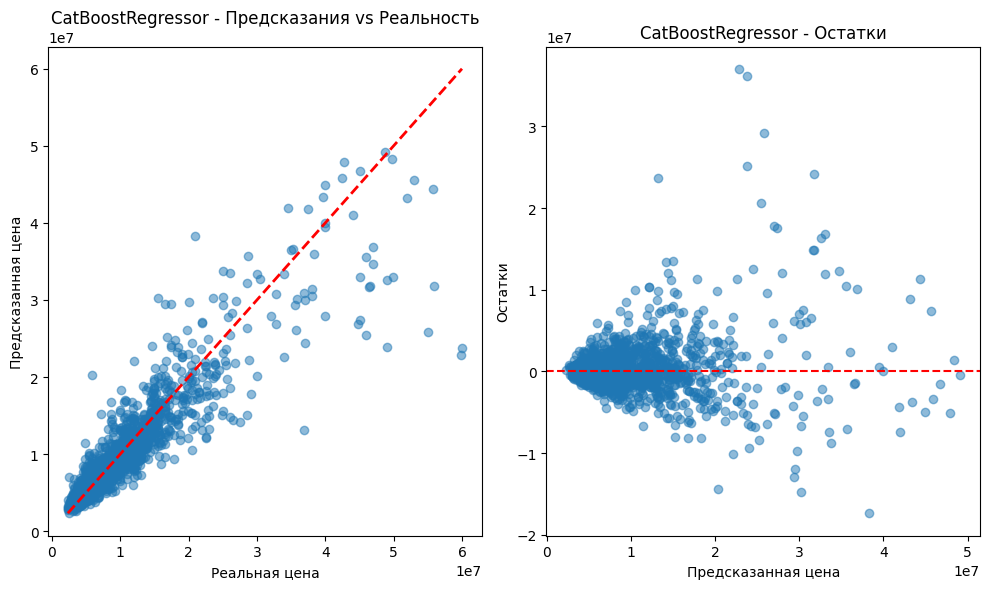

['best_real_estate_model.pkl']

In [8]:
# 1. Выбор лучшей модели по CV
best_model_name = 'CatBoostRegressor' # Замените на модель с лучшими CV scores
best_model = models[best_model_name]

# 2. Финальное обучение и оценка
y_pred, final_metrics = final_training_and_evaluation(
    best_model, X_train, y_train_log, X_test, y_test_log, y_test
)

# 3. Визуализация
plot_predictions(y_test, y_pred, best_model_name)

# 4. Сохранение модели
import joblib
joblib.dump(best_model, 'best_real_estate_model.pkl')